In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

#from sequence_logo_helper import plot_dna_logo

import pandas as pd
'''
from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()
'''
class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

from scipy.stats import pearsonr, spearmanr


Using TensorFlow backend.
2022-10-13 00:55:11.125910: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [3]:
#Load data features

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")

#Include cell types
'''
included_cell_types = [
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5',
]
'''
included_cell_types = [
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5',
]

x, m, l, c, y, s = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

#Add extra singleton dim to x
x = np.expand_dims(x, axis=2)

#Shuffle c and y dimensions
c = np.transpose(c, (0, 2, 1))
y = np.transpose(y, (0, 2, 1))

#Slice celltypes

included_cell_type_ixs = [cell_type_dict[cell_type] for cell_type in included_cell_types]

cell_types = cell_types[included_cell_type_ixs]
c = c[:, included_cell_type_ixs, :]
y = y[:, included_cell_type_ixs, :]
s = s[:, included_cell_type_ixs]

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (5267, 10, 1, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 11, 10)
y.shape = (5267, 11, 10)
s.shape = (5267, 11)


In [4]:
#Collapse/omit PASes that are to close in spatial distance

collapse_if_within = 50.
omit_if_within = 100.

for i in range(x.shape[0]) :
    
    curr_pas = 0
    next_pas = 1
    
    while next_pas < x.shape[1] :
        
        if m[i, next_pas] <= 0. :
            break
        
        if l[i, next_pas] <= collapse_if_within :
            
            x[i, next_pas:-1, ...] = x[i, next_pas+1:, ...]
            
            c[i, :, curr_pas] += c[i, :, next_pas]
            c[i, :, next_pas:-1] = c[i, :, next_pas+1:]
            
            m[i, next_pas:-1] = m[i, next_pas+1:]
            
            temp_l = l[i, next_pas]
            l[i, next_pas:-1] = l[i, next_pas+1:]
            
            if m[i, next_pas] == 1. :
                l[i, next_pas] += temp_l
            
            next_pas -= 1
            
        elif l[i, next_pas] <= omit_if_within :
            
            x[i, next_pas:-1, ...] = x[i, next_pas+1:, ...]
            c[i, :, next_pas:-1] = c[i, :, next_pas+1:]
            m[i, next_pas:-1] = m[i, next_pas+1:]
            
            temp_l = l[i, next_pas]
            l[i, next_pas:-1] = l[i, next_pas+1:]
            
            if m[i, next_pas] == 1. :
                l[i, next_pas] += temp_l
            
            next_pas -= 1
            
        else :
            curr_pas += 1
        
        next_pas += 1


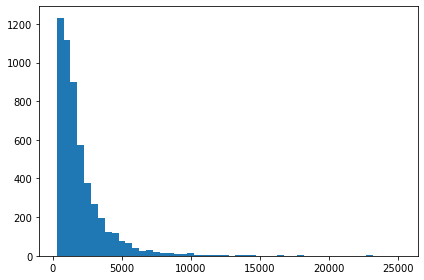

In [5]:

f = plt.figure(figsize=(6, 4))

plt.hist(np.minimum(np.max(l, axis=1), 120000.), bins=50)

plt.tight_layout()

plt.show()


In [6]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 0.

x = x[:, :max_n_pas, ...]
m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

x = x[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), ...]
m = m[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), :]
l = l[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), :]
c = c[(np.all(total_c > min_total_count, axis=-1) & (total_m >= 2)) & (max_l < 40000.), ...]

y = c / np.sum(c, axis=2, keepdims=True)
y[np.isnan(y)] = 0.

s = np.array(np.sum(c, axis=2) > 0, dtype=np.float)

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (5239, 10, 1, 205, 4)
m.shape = (5239, 10)
l.shape = (5239, 10)
c.shape = (5239, 11, 10)
y.shape = (5239, 11, 10)
s.shape = (5239, 11)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:

cell_type_differences = [
    ['NT', cell_type] for cell_type in cell_types[1:].tolist()
]

d = np.zeros((x.shape[0], s.shape[1], s.shape[1]))

for [cell_type_1, cell_type_2] in cell_type_differences :
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]
    
    d[:, cell_type_1_ix, cell_type_2_ix] = 1.

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))
print("d.shape = " + str(d.shape))


x.shape = (5239, 10, 1, 205, 4)
m.shape = (5239, 10)
l.shape = (5239, 10)
c.shape = (5239, 11, 10)
y.shape = (5239, 11, 10)
s.shape = (5239, 11)
d.shape = (5239, 11, 11)


In [8]:
#Log-transform feature matrix l

l = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.maximum(l - 5., 0)


In [9]:
#Create proximal and distal masks

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

prox_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    prox_mask[i, prox_index[i]] = 1.

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [10]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'

save_dir = os.path.join(os.getcwd(), '')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent = load_model(model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
#Score all sequences with APARENT (use sum of cuts to capture OR-like logic)

isoform_start = 77
isoform_end = 127

a = np.zeros((x.shape[0], x.shape[1]))
for k in range(x.shape[1]) :
    
    print("Predicting for PAS #" + str(k) + "...")
    
    onehots = x[:, k, ...]
    
    fake_lib = np.zeros((onehots.shape[0], 13))
    fake_lib[:, 11] = 1.
    
    #Pad
    n_pad = 32 - onehots.shape[0] % 32 if onehots.shape[0] % 32 != 0 else 0

    fake_lib = np.concatenate([fake_lib, np.zeros((n_pad, 13))], axis=0)
    onehots = np.concatenate([onehots, np.zeros((n_pad, 1, 205, 4))], axis=0)
    
    _, pred_cuts = aparent.predict(x=[onehots, fake_lib], batch_size=32, verbose=1)
    
    if n_pad > 0 :
        pred_cuts = pred_cuts[:-n_pad, :]
    
    pred_iso = np.sum(pred_cuts[:, isoform_start:isoform_end], axis=1)
    pred_logit = np.log(pred_iso / (1. - pred_iso))
    
    a[:, k] = pred_logit[:]

a = a * m
a = np.clip(a, -10., 10.)


Predicting for PAS #0...


2022-05-29 22:45:03.860680: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8
2022-05-29 22:45:11.684859: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


3904/3904 [==============================] - 15s 4ms/step
Predicting for PAS #1...
3904/3904 [==============================] - 3s 773us/step
Predicting for PAS #2...
3904/3904 [==============================] - 3s 773us/step
Predicting for PAS #3...
3904/3904 [==============================] - 3s 773us/step
Predicting for PAS #4...
3904/3904 [==============================] - 3s 776us/step
Predicting for PAS #5...
3904/3904 [==============================] - 3s 773us/step
Predicting for PAS #6...
3904/3904 [==============================] - 3s 770us/step
Predicting for PAS #7...
3904/3904 [==============================] - 3s 771us/step
Predicting for PAS #8...
3904/3904 [==============================] - 3s 771us/step
Predicting for PAS #9...
3904/3904 [==============================] - 3s 772us/step


In [10]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_scores", a)
a = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_scores.npy")

print(a.shape)


(5239, 10)


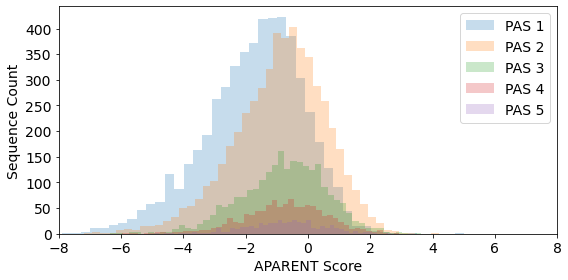

In [11]:
#Plot distribution of APARENT scores per PAS

f = plt.figure(figsize=(8, 4))

plt.hist(a[:, 0][m[:, 0] >= 1.], bins=50, alpha=0.25, label="PAS 1")
plt.hist(a[:, 1][m[:, 1] >= 1.], bins=50, alpha=0.25, label="PAS 2")
plt.hist(a[:, 2][m[:, 2] >= 1.], bins=50, alpha=0.25, label="PAS 3")
plt.hist(a[:, 3][m[:, 3] >= 1.], bins=50, alpha=0.25, label="PAS 4")
plt.hist(a[:, 4][m[:, 4] >= 1.], bins=50, alpha=0.25, label="PAS 5")

plt.legend(fontsize=14)

plt.xlim(-8., 8.)
plt.ylim(0.)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("APARENT Score", fontsize=14)
plt.ylabel("Sequence Count", fontsize=14)

plt.tight_layout()

plt.show()


In [12]:
#PAS network definition

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func


In [13]:
#Define model code

def get_kl_divergence(max_n_pas, n_cell_types) :

    def _kl_divergence(y_true, y_pred, pas_mask, cell_type_mask, max_n_pas=max_n_pas, n_cell_types=n_cell_types) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())

        kl = y_true * K.log(y_true / y_pred)
        kl = kl * K.tile(K.expand_dims(cell_type_mask, axis=-1), (1, 1, max_n_pas))
        kl = kl * K.tile(K.expand_dims(pas_mask, axis=1), (1, n_cell_types, 1))
        total_kl = K.sum(kl, axis=-1)

        mean_total_kl = K.mean(total_kl, axis=-1)

        return mean_total_kl

    return _kl_divergence

def get_difference_mse(max_n_pas, n_cell_types) :

    def _difference_mse(y_true, y_pred, pas_mask, cell_type_mask, diff_mask, max_n_pas=max_n_pas, n_cell_types=n_cell_types) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())

        y_true_1 = K.expand_dims(y_true, axis=1)
        y_true_2 = K.expand_dims(y_true, axis=2)
        y_true_diff = y_true_1 - y_true_2

        y_pred_1 = K.expand_dims(y_pred, axis=1)
        y_pred_2 = K.expand_dims(y_pred, axis=2)
        y_pred_diff = y_pred_1 - y_pred_2

        cell_type_mask_1 = K.tile(K.expand_dims(K.expand_dims(cell_type_mask, axis=1), axis=-1), (1, 1, 1, max_n_pas))
        cell_type_mask_2 = K.tile(K.expand_dims(K.expand_dims(cell_type_mask, axis=2), axis=-1), (1, 1, 1, max_n_pas))
        cell_type_mask_diff = cell_type_mask_1 * cell_type_mask_2

        pas_mask_diff = K.tile(K.expand_dims(K.expand_dims(pas_mask, axis=1), axis=1), (1, n_cell_types, n_cell_types, 1))

        diff_mask_diff = cell_type_mask_2 = K.tile(K.expand_dims(diff_mask, axis=-1), (1, 1, 1, max_n_pas))

        net_mask_diff = pas_mask_diff * cell_type_mask_diff * diff_mask_diff

        margin_error = K.maximum(K.sign(y_true_diff) * (y_true_diff - y_pred_diff), 0.)
        se = K.switch(K.abs(y_true_diff) * net_mask_diff > 0.05, margin_error, K.zeros_like(y_true_diff))

        mse = K.mean(se, axis=(1, 2, 3))

        return mse

    return _difference_mse

def get_weighted_loss(loss_coeff=1.) :

    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred

    return _min_pred

def initialize_model() :
    
    #Initialize PAS feature extractor network
    
    n_cell_types = y.shape[-2]

    #Load PAS network
    pas_net = load_pas_network(
        n_cell_types=n_cell_types
    )
    
    #Build predictor model
    #max_n_pas = 16

    pas_sequence = Input(shape=(max_n_pas, 1, 205, 4), name='pas_sequence')
    pas_mask = Input(shape=(max_n_pas,), name='pas_mask')
    prox_mask = Input(shape=(max_n_pas,), name='prox_mask')
    dist_mask = Input(shape=(max_n_pas,), name='dist_mask')
    pas_length = Input(shape=(max_n_pas,), name='pas_length')
    aparent_score = Input(shape=(max_n_pas,), name='aparent_score')

    #Initialize and execute Lambda split layers
    pas_sequences = []
    for i in range(max_n_pas) :
        split_pas_sequence = Lambda(lambda x, pas_ix=i: x[:, pas_ix, ...], name="split_pas_sequence_" + str(i))
        pas_sequences.append(split_pas_sequence(pas_sequence))

    #Execute PAS feature extractor on sequences
    pas_scores_per_pas = []
    for i in range(max_n_pas) :
        pas_score = pas_net(pas_sequences[i])
        expand_pas_score = Lambda(lambda x: K.expand_dims(x, axis=-1), name="expand_pas_score_" + str(i))
        pas_scores_per_pas.append(expand_pas_score(pas_score))

    concat_pas_scores = Lambda(lambda x: K.permute_dimensions(K.concatenate(x, axis=-1), (0, 3, 1, 2)), name='concat_pas_scores')
    pas_score = concat_pas_scores(pas_scores_per_pas)
    
    concat_pas_scores_middle = Lambda(lambda x: K.permute_dimensions(K.concatenate(x[:-2], axis=-1)[:, :, 1, :], (0, 2, 1)) * (K.ones_like(x[-1]) - x[-1] - x[-2])[:, :, None], name='concat_pas_scores_middle')
    pas_score_middle = concat_pas_scores_middle(pas_scores_per_pas + [prox_mask, dist_mask])
    
    concat_use_scores_prox = Lambda(lambda x: K.permute_dimensions(K.concatenate(x[:-1], axis=-1)[:, :, 0, :], (0, 2, 1)) * x[-1][:, :, None], name='concat_use_scores_prox')
    use_score_prox = concat_use_scores_prox(pas_scores_per_pas + [prox_mask])
    
    concat_dse_scores_dist = Lambda(lambda x: K.permute_dimensions(K.concatenate(x[:-1], axis=-1)[:, :, 2, :], (0, 2, 1)) * x[-1][:, :, None], name='concat_dse_scores_dist')
    dse_score_dist = concat_dse_scores_dist(pas_scores_per_pas + [dist_mask])

    pas_features_per_cell_type_shared = []
    pas_features_per_cell_type_specific = []
    for i in range(n_cell_types) :# + K.expand_dims(x[3][..., pas_ix], axis=-1) + K.expand_dims(x[4][..., pas_ix], axis=-1)
        #make_pas_feature_shared = Lambda(lambda x, pas_ix=i: K.concatenate([K.expand_dims(x[0][..., pas_ix], axis=-1) + K.expand_dims(x[2], axis=-1), K.expand_dims(x[1], axis=-1)], axis=-1), name="make_pas_feature_shared_" + str(i))
        make_pas_feature_shared = Lambda(lambda x, pas_ix=i: K.concatenate([K.expand_dims(x[0][..., pas_ix], axis=-1) + K.expand_dims(x[2], axis=-1) + K.expand_dims(x[3][..., pas_ix], axis=-1) + K.expand_dims(x[4][..., pas_ix], axis=-1), K.expand_dims(x[1], axis=-1)], axis=-1), name="make_pas_feature_shared_" + str(i))
        pas_features_per_cell_type_shared.append(make_pas_feature_shared([pas_score_middle, pas_length, aparent_score, use_score_prox, dse_score_dist]))
        
        make_pas_feature_specific = Lambda(lambda x, pas_ix=i: K.ones_like(K.expand_dims(x, axis=-1)), name="make_pas_feature_specific_" + str(i))
        pas_features_per_cell_type_specific.append(make_pas_feature_specific(pas_length))

    rnn_shared = Conv1D(1, (1,), activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='apa_rnn_layer')
    
    apa_scores_per_cell_type_shared = []
    apa_scores_per_cell_type_specific = []
    for i in range(n_cell_types) :
        rnn_specific = LocallyConnected1D(1, (1,), activation='linear', kernel_initializer='zeros', use_bias=False, name='apa_rnn_layer_' + str(i))
        
        apa_scores_shared = rnn_shared(pas_features_per_cell_type_shared[i])
        apa_scores_specific = rnn_specific(pas_features_per_cell_type_specific[i])

        expand_apa_score_shared = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 1)), name='expand_apa_score_shared_' + str(i))
        apa_scores_per_cell_type_shared.append(expand_apa_score_shared(apa_scores_shared))
        
        expand_apa_score_specific = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 1)), name='expand_apa_score_specific_' + str(i))
        apa_scores_per_cell_type_specific.append(expand_apa_score_specific(apa_scores_specific))

    concat_apa_scores_shared = Lambda(lambda x: K.concatenate(x, axis=1), name='concat_apa_scores_shared')
    apa_score_shared = concat_apa_scores_shared(apa_scores_per_cell_type_shared)
    
    concat_apa_scores_specific = Lambda(lambda x: K.concatenate(x, axis=1), name='concat_apa_scores_specific')
    apa_score_specific = concat_apa_scores_specific(apa_scores_per_cell_type_specific)

    add_apa_scores = Lambda(lambda x: x[0] + x[1], name='add_apa_scores')
    apa_score = add_apa_scores([apa_score_shared, apa_score_specific])
    
    #Define masked softmax function
    def _masked_softmax(y, m, axis=-1) :

        exp_y = m * (K.exp(y) + K.epsilon())

        return exp_y / K.expand_dims(K.sum(exp_y, axis=axis), axis=axis)

    tile_mask = Lambda(lambda x, n_cell_types=n_cell_types: K.tile(K.expand_dims(x, axis=1), (1, n_cell_types, 1)), name="tile_mask")

    tiled_pas_mask = tile_mask(pas_mask)

    masked_softmax = Lambda(lambda x: _masked_softmax(x[0], x[1], axis=-1), name="masked_softmax")

    apa_prob = masked_softmax([apa_score, tiled_pas_mask])

    #Build PAS model
    pas_model = Model([pas_sequence], [pas_score])
    pas_model.get_layer("pasnet_dense_2").trainable = False

    pas_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )
    
    #Build APA model
    apa_model = Model([pas_sequence, pas_mask, prox_mask, dist_mask, pas_length, aparent_score], [apa_score, apa_prob])

    apa_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    #Define loss model
    apa_target = Input(shape=(n_cell_types, max_n_pas), name='apa_target')
    apa_support = Input(shape=(n_cell_types,), name='apa_support')
    apa_diff_mask = Input(shape=(n_cell_types, n_cell_types,), name='apa_diff_mask')

    #NLL cost
    nll_loss_func = get_kl_divergence(max_n_pas, n_cell_types)

    #Difference MSE cost
    diff_loss_func = get_difference_mse(max_n_pas, n_cell_types)

    #Execute NLL cost
    nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1], x[2], x[3]), name='nll')([
        apa_target,
        apa_prob,
        pas_mask,
        apa_support
    ])

    #Execute Difference MSE cost
    diff_loss = Lambda(lambda x: diff_loss_func(x[0], x[1], x[2], x[3], x[4]), name='difference')([
        apa_target,
        apa_prob,
        pas_mask,
        apa_support,
        apa_diff_mask
    ])

    loss_model = Model(
        [pas_sequence, pas_mask, prox_mask, dist_mask, pas_length, aparent_score, apa_target, apa_support, apa_diff_mask],
        [nll_loss, diff_loss]
    )

    loss_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss={
            'nll' : get_weighted_loss(loss_coeff=1.0),
            'difference' : get_weighted_loss(loss_coeff=0.),
        }
    )
    
    return pas_model, apa_model, loss_model


In [14]:
#Train n bootstrap models

from sklearn.model_selection import KFold

n_folds = 10
n_valid = 500

train_histories = []

model_name = "perturb_resnet_utr3_covar_drop_crossval_retry_2"

kf = KFold(n_splits=n_folds)

for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
    print("Fold = " + str(fold_ix))
    
    #Clear keras session
    K.clear_session()
    
    #Create data fold
    x_train_curr = x[train_index[:-n_valid], ...]
    m_train_curr = m[train_index[:-n_valid], ...]
    prox_mask_train_curr = prox_mask[train_index[:-n_valid], ...]
    dist_mask_train_curr = dist_mask[train_index[:-n_valid], ...]
    l_train_curr = l[train_index[:-n_valid], ...]
    c_train_curr = c[train_index[:-n_valid], ...]
    y_train_curr = y[train_index[:-n_valid], ...]
    s_train_curr = s[train_index[:-n_valid], ...]
    d_train_curr = d[train_index[:-n_valid], ...]
    a_train_curr = a[train_index[:-n_valid], ...]

    x_valid_curr = x[train_index[-n_valid:], ...]
    m_valid_curr = m[train_index[-n_valid:], ...]
    prox_mask_valid_curr = prox_mask[train_index[-n_valid:], ...]
    dist_mask_valid_curr = dist_mask[train_index[-n_valid:], ...]
    l_valid_curr = l[train_index[-n_valid:], ...]
    c_valid_curr = c[train_index[-n_valid:], ...]
    y_valid_curr = y[train_index[-n_valid:], ...]
    s_valid_curr = s[train_index[-n_valid:], ...]
    d_valid_curr = d[train_index[-n_valid:], ...]
    a_valid_curr = a[train_index[-n_valid:], ...]
    
    dummy_train = np.zeros((x_train_curr.shape[0], 1))
    dummy_valid = np.zeros((x_valid_curr.shape[0], 1))
    
    pas_model, apa_model, loss_model = initialize_model()
    
    #Execute training procedure

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    
    import pickle
    regr_dict = pickle.load(open("perturb_utr3_pas_and_cell_type_shared_and_specific_regr.pickle", 'rb'))
    
    apa_model.get_layer("apa_rnn_layer").set_weights([
        regr_dict['rnn_w'],
        regr_dict['rnn_b'],
    ])

    loss_model.get_layer("apa_rnn_layer").set_weights([
        regr_dict['rnn_w'],
        regr_dict['rnn_b'],
    ])
    
    for i in range(y.shape[-2]) :
        apa_model.get_layer("apa_rnn_layer_" + str(i)).set_weights([
            regr_dict['rnn_' + str(i) + '_w'],
        ])
        
        loss_model.get_layer("apa_rnn_layer_" + str(i)).set_weights([
            regr_dict['rnn_' + str(i) + '_w'],
        ])
    
    #1: Train model to fit APARENT score parameters
    _ = loss_model.fit(
        [x_train_curr, m_train_curr, prox_mask_train_curr, dist_mask_train_curr, l_train_curr, a_train_curr, y_train_curr, s_train_curr, d_train_curr],
        [dummy_train, dummy_train],
        shuffle=True,
        epochs=0,
        batch_size=32,
        validation_data=(
            [x_valid_curr, m_valid_curr, prox_mask_valid_curr, dist_mask_valid_curr, l_valid_curr, a_valid_curr, y_valid_curr, s_valid_curr, d_valid_curr],
            [dummy_valid, dummy_valid]
        ),
        callbacks=[early_stop],
        verbose = 1
    )
    
    #Re-compile PAS model with trainable feature detector
    pas_model.get_layer("pasnet_dense_2").trainable = True
    pas_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    apa_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss='mean_squared_error'
    )

    loss_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        loss={
            'nll' : get_weighted_loss(loss_coeff=0.5),
            'difference' : get_weighted_loss(loss_coeff=200.),#500.
        }
    )

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

    #2: Train tissue-specific APA model
    train_history = loss_model.fit(
        [x_train_curr, m_train_curr, prox_mask_train_curr, dist_mask_train_curr, l_train_curr, a_train_curr, y_train_curr, s_train_curr, d_train_curr],
        [dummy_train, dummy_train],
        shuffle=True,
        epochs=100,
        batch_size=32,
        validation_data=(
            [x_valid_curr, m_valid_curr, prox_mask_valid_curr, dist_mask_valid_curr, l_valid_curr, a_valid_curr, y_valid_curr, s_valid_curr, d_valid_curr],
            [dummy_valid, dummy_valid]
        ),
        callbacks=[early_stop],
        verbose = 1
    )
    
    train_histories.append(train_history)
    
    #Save model(s)
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '_fold_' + str(fold_ix) + '_pas_model' + '.h5')

    pas_model.save(model_path)
    print('Saved pas model at %s ' % (model_path))

    model_path = os.path.join(save_dir, model_name + '_fold_' + str(fold_ix) + '_apa_model' + '.h5')

    apa_model.save(model_path)
    print('Saved apa model at %s ' % (model_path))


Fold = 0


2022-10-13 00:55:34.507602: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-13 00:55:35.177177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 00:55:35.177783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 00:55:35.177813: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 00:55:35.181169: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 00:55:35.182498: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100


2022-10-13 00:56:00.240605: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 00:56:00.595923: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


4215/4215 [==============================] - 44s 10ms/step - loss: 0.3332 - nll_loss: 0.1566 - difference_loss: 0.1766 - val_loss: 0.3522 - val_nll_loss: 0.1484 - val_difference_loss: 0.2032
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3260 - nll_loss: 0.1536 - difference_loss: 0.1723 - val_loss: 0.3337 - val_nll_loss: 0.1491 - val_difference_loss: 0.1841
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3249 - nll_loss: 0.1539 - difference_loss: 0.1710 - val_loss: 0.3384 - val_nll_loss: 0.1470 - val_difference_loss: 0.1907
Epoch 4/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3239 - nll_loss: 0.1536 - difference_loss: 0.1703 - val_loss: 0.3372 - val_nll_loss: 0.1471 - val_difference_loss: 0.1894
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3232 - nll_loss: 0.1530 - difference_loss: 0.1702 - val_loss: 0.3377 - val_nll_loss: 0.1465 - val_difference_loss: 0.1905
E

2022-10-13 01:47:19.088886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:47:19.089285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 01:47:19.089370: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 01:47:19.089424: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 01:47:19.089448: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 01:47:19.089466: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 41s 10ms/step - loss: 0.3287 - nll_loss: 0.1551 - difference_loss: 0.1737 - val_loss: 0.3447 - val_nll_loss: 0.1471 - val_difference_loss: 0.1969
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3237 - nll_loss: 0.1528 - difference_loss: 0.1708 - val_loss: 0.3385 - val_nll_loss: 0.1475 - val_difference_loss: 0.1903
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3236 - nll_loss: 0.1525 - difference_loss: 0.1711 - val_loss: 0.3429 - val_nll_loss: 0.1472 - val_difference_loss: 0.1950
Epoch 4/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3215 - nll_loss: 0.1529 - difference_loss: 0.1686 - val_loss: 0.3438 - val_nll_loss: 0.1462 - val_difference_loss: 0.1970
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3217 - nll_loss: 

2022-10-13 02:38:38.996848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 02:38:38.997277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 02:38:38.997369: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 02:38:38.997436: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 02:38:38.997458: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 02:38:38.997475: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 40s 9ms/step - loss: 0.3312 - nll_loss: 0.1546 - difference_loss: 0.1765 - val_loss: 0.3442 - val_nll_loss: 0.1491 - val_difference_loss: 0.1945
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3228 - nll_loss: 0.1519 - difference_loss: 0.1709 - val_loss: 0.3462 - val_nll_loss: 0.1460 - val_difference_loss: 0.1997
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3224 - nll_loss: 0.1516 - difference_loss: 0.1709 - val_loss: 0.3447 - val_nll_loss: 0.1464 - val_difference_loss: 0.1977
Epoch 4/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3221 - nll_loss: 0.1513 - difference_loss: 0.1708 - val_loss: 0.3378 - val_nll_loss: 0.1467 - val_difference_loss: 0.1906
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3213 - nll_loss: 0

2022-10-13 03:24:12.089258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 03:24:12.089832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 03:24:12.089964: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 03:24:12.090062: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 03:24:12.090134: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 03:24:12.090189: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 40s 9ms/step - loss: 0.3323 - nll_loss: 0.1561 - difference_loss: 0.1764 - val_loss: 0.3368 - val_nll_loss: 0.1498 - val_difference_loss: 0.1863
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3264 - nll_loss: 0.1541 - difference_loss: 0.1723 - val_loss: 0.3353 - val_nll_loss: 0.1484 - val_difference_loss: 0.1862
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3256 - nll_loss: 0.1538 - difference_loss: 0.1720 - val_loss: 0.3407 - val_nll_loss: 0.1468 - val_difference_loss: 0.1933
Epoch 4/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3245 - nll_loss: 0.1534 - difference_loss: 0.1710 - val_loss: 0.3363 - val_nll_loss: 0.1479 - val_difference_loss: 0.1877
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3245 - nll_loss: 0

2022-10-13 04:14:29.282550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 04:14:29.282902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 04:14:29.282984: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 04:14:29.283041: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 04:14:29.283058: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 04:14:29.283072: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 40s 9ms/step - loss: 0.3292 - nll_loss: 0.1557 - difference_loss: 0.1735 - val_loss: 0.3396 - val_nll_loss: 0.1474 - val_difference_loss: 0.1915
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3225 - nll_loss: 0.1536 - difference_loss: 0.1691 - val_loss: 0.3426 - val_nll_loss: 0.1478 - val_difference_loss: 0.1943
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3219 - nll_loss: 0.1533 - difference_loss: 0.1686 - val_loss: 0.3411 - val_nll_loss: 0.1481 - val_difference_loss: 0.1923
Epoch 4/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3209 - nll_loss: 0.1534 - difference_loss: 0.1675 - val_loss: 0.3388 - val_nll_loss: 0.1470 - val_difference_loss: 0.1911
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3188 - nll_loss: 0

2022-10-13 05:05:56.162374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 05:05:56.162747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 05:05:56.162807: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 05:05:56.162851: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 05:05:56.162871: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 05:05:56.162886: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 38s 9ms/step - loss: 0.3298 - nll_loss: 0.1563 - difference_loss: 0.1733 - val_loss: 0.3422 - val_nll_loss: 0.1471 - val_difference_loss: 0.1943
Epoch 2/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3239 - nll_loss: 0.1542 - difference_loss: 0.1696 - val_loss: 0.3381 - val_nll_loss: 0.1467 - val_difference_loss: 0.1908
Epoch 3/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3232 - nll_loss: 0.1541 - difference_loss: 0.1691 - val_loss: 0.3418 - val_nll_loss: 0.1472 - val_difference_loss: 0.1942
Epoch 4/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3227 - nll_loss: 0.1543 - difference_loss: 0.1684 - val_loss: 0.3425 - val_nll_loss: 0.1462 - val_difference_loss: 0.1957
Epoch 5/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3208 - nll_loss: 0

2022-10-13 05:57:35.577394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 05:57:35.577788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 05:57:35.577859: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 05:57:35.577939: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 05:57:35.577980: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 05:57:35.578015: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 40s 9ms/step - loss: 0.3302 - nll_loss: 0.1556 - difference_loss: 0.1745 - val_loss: 0.3392 - val_nll_loss: 0.1496 - val_difference_loss: 0.1889
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3237 - nll_loss: 0.1538 - difference_loss: 0.1700 - val_loss: 0.3384 - val_nll_loss: 0.1473 - val_difference_loss: 0.1904
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3229 - nll_loss: 0.1535 - difference_loss: 0.1694 - val_loss: 0.3367 - val_nll_loss: 0.1478 - val_difference_loss: 0.1883
Epoch 4/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3222 - nll_loss: 0.1537 - difference_loss: 0.1684 - val_loss: 0.3391 - val_nll_loss: 0.1460 - val_difference_loss: 0.1924
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3189 - nll_loss: 0

2022-10-13 06:44:53.062399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 06:44:53.062763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 06:44:53.062834: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 06:44:53.062897: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 06:44:53.062921: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 06:44:53.062938: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 41s 10ms/step - loss: 0.3291 - nll_loss: 0.1545 - difference_loss: 0.1745 - val_loss: 0.3425 - val_nll_loss: 0.1479 - val_difference_loss: 0.1938
Epoch 2/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3242 - nll_loss: 0.1530 - difference_loss: 0.1713 - val_loss: 0.3408 - val_nll_loss: 0.1471 - val_difference_loss: 0.1931
Epoch 3/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3232 - nll_loss: 0.1525 - difference_loss: 0.1706 - val_loss: 0.3379 - val_nll_loss: 0.1473 - val_difference_loss: 0.1900
Epoch 4/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3224 - nll_loss: 0.1523 - difference_loss: 0.1702 - val_loss: 0.3340 - val_nll_loss: 0.1489 - val_difference_loss: 0.1846
Epoch 5/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3210 - nll_loss: 

2022-10-13 07:36:32.874568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 07:36:32.874978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 07:36:32.875061: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 07:36:32.875110: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 07:36:32.875124: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 07:36:32.875135: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4215 samples, validate on 500 samples
Train on 4215 samples, validate on 500 samples
Epoch 1/100
4215/4215 [==============================] - 40s 9ms/step - loss: 0.3320 - nll_loss: 0.1567 - difference_loss: 0.1753 - val_loss: 0.3425 - val_nll_loss: 0.1490 - val_difference_loss: 0.1930
Epoch 2/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3252 - nll_loss: 0.1540 - difference_loss: 0.1712 - val_loss: 0.3459 - val_nll_loss: 0.1476 - val_difference_loss: 0.1977
Epoch 3/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3246 - nll_loss: 0.1541 - difference_loss: 0.1704 - val_loss: 0.3419 - val_nll_loss: 0.1474 - val_difference_loss: 0.1938
Epoch 4/100
4215/4215 [==============================] - 30s 7ms/step - loss: 0.3233 - nll_loss: 0.1540 - difference_loss: 0.1693 - val_loss: 0.3368 - val_nll_loss: 0.1474 - val_difference_loss: 0.1888
Epoch 5/100
4215/4215 [==============================] - 31s 7ms/step - loss: 0.3228 - nll_loss: 0

2022-10-13 08:24:25.332477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 08:24:25.332859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 08:24:25.332923: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 08:24:25.332971: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 08:24:25.332998: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 08:24:25.333034: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

Train on 4216 samples, validate on 500 samples
Train on 4216 samples, validate on 500 samples
Epoch 1/100
4216/4216 [==============================] - 39s 9ms/step - loss: 0.3305 - nll_loss: 0.1564 - difference_loss: 0.1742 - val_loss: 0.3323 - val_nll_loss: 0.1452 - val_difference_loss: 0.1868
Epoch 2/100
4216/4216 [==============================] - 30s 7ms/step - loss: 0.3256 - nll_loss: 0.1534 - difference_loss: 0.1722 - val_loss: 0.3225 - val_nll_loss: 0.1455 - val_difference_loss: 0.1770
Epoch 3/100
4216/4216 [==============================] - 31s 7ms/step - loss: 0.3238 - nll_loss: 0.1532 - difference_loss: 0.1706 - val_loss: 0.3241 - val_nll_loss: 0.1451 - val_difference_loss: 0.1789
Epoch 4/100
4216/4216 [==============================] - 30s 7ms/step - loss: 0.3234 - nll_loss: 0.1534 - difference_loss: 0.1700 - val_loss: 0.3291 - val_nll_loss: 0.1449 - val_difference_loss: 0.1842
Epoch 5/100
4216/4216 [==============================] - 31s 7ms/step - loss: 0.3231 - nll_loss: 0

In [15]:

pas_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pas_sequence (InputLayer)       (None, 10, 1, 205, 4 0                                            
__________________________________________________________________________________________________
split_pas_sequence_0 (Lambda)   (None, 1, 205, 4)    0           pas_sequence[0][0]               
__________________________________________________________________________________________________
split_pas_sequence_1 (Lambda)   (None, 1, 205, 4)    0           pas_sequence[0][0]               
__________________________________________________________________________________________________
split_pas_sequence_2 (Lambda)   (None, 1, 205, 4)    0           pas_sequence[0][0]               
____________________________________________________________________________________________

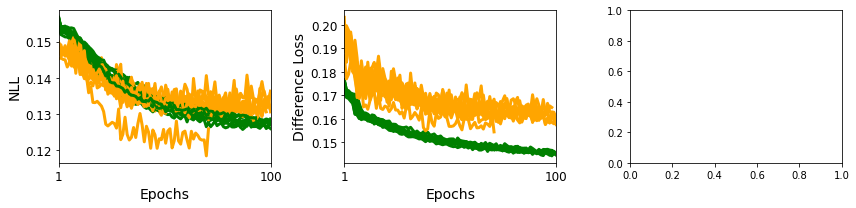

In [16]:
#Plot bootstrap training and validation losses

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

max_n_epochs_actual = 0

for bootstrap_ix in range(len(train_histories)) :
    
    train_history = train_histories[bootstrap_ix]

    n_epochs_actual = len(train_history.history['nll_loss'])
    max_n_epochs_actual = max(max_n_epochs_actual, n_epochs_actual)
    
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['difference_loss'], linewidth=3, color='green')
    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_difference_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, max_n_epochs_actual)
plt.xticks([1, max_n_epochs_actual], [1, max_n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Difference Loss", fontsize=14)
plt.xlim(1, max_n_epochs_actual)
plt.xticks([1, max_n_epochs_actual], [1, max_n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [17]:
#Specify cell type labels

print(cell_types)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


['NT' 'CPSF4' 'CPSF6' 'CSTF1' 'CSTF3' 'FIP1L1' 'NUDT21' 'RBBP6' 'SRSF3'
 'SYMPK' 'THOC5']


In [26]:
#Cross-evaluate models on test folds

from sklearn.model_selection import KFold

n_folds = 10

y_pred_score = np.zeros((x.shape[0], y.shape[-2], y.shape[-1]))
y_pred_prob = np.zeros((x.shape[0], y.shape[-2], y.shape[-1]))

kf = KFold(n_splits=n_folds)

attempt_strs = ["", "_retry_1", "_retry_2"]

for attempt_str in attempt_strs :
    for fold_ix, [_, test_index] in enumerate(kf.split(s)) :

        #Clear keras session
        K.clear_session()

        print("Predicting using model " + str(fold_ix) + "...")

        pas_model, apa_model, _ = initialize_model()

        #Load model(s)
        model_name = "perturb_resnet_utr3_covar_drop_crossval"

        save_dir = 'saved_models'

        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        model_path = os.path.join(save_dir, model_name + attempt_str + '_fold_' + str(fold_ix) + '_pas_model' + '.h5')
        #pas_model = load_model(model_path)
        pas_model.load_weights(model_path)

        def _masked_softmax(y, m, axis=-1) :

            exp_y = m * (K.exp(y) + K.epsilon())

            return exp_y / K.expand_dims(K.sum(exp_y, axis=axis), axis=axis)

        model_path = os.path.join(save_dir, model_name + attempt_str + '_fold_' + str(fold_ix) + '_apa_model' + '.h5')
        #apa_model = load_model(model_path, custom_objects={
        #    '_masked_softmax' : _masked_softmax
        #})
        apa_model.load_weights(model_path)

        #Create test fold
        x_test = x[test_index, ...]
        m_test = m[test_index, ...]
        prox_mask_test = prox_mask[test_index, ...]
        dist_mask_test = dist_mask[test_index, ...]
        l_test = l[test_index, ...]
        a_test = a[test_index, ...]

        #Make predictions on test data
        y_pred_score_test, y_pred_prob_test = apa_model.predict(x=[x_test, m_test, prox_mask_test, dist_mask_test, l_test, a_test], batch_size=64, verbose=True)

        y_pred_score[test_index, ...] += y_pred_score_test[:, ...]
        y_pred_prob[test_index, ...] += y_pred_prob_test[:, ...]

y_pred_score /= len(attempt_strs)
y_pred_prob /= len(attempt_strs)


Predicting using model 0...


2022-10-13 14:48:04.407709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:04.408547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:04.408671: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:04.408757: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:04.408810: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:04.408863: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 3s 5ms/step
Predicting using model 1...


2022-10-13 14:48:12.886786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:12.887573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:12.887707: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:12.887797: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:12.887858: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:12.887905: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 3s 5ms/step
Predicting using model 2...


2022-10-13 14:48:20.140030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:20.140357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:20.140402: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:20.140435: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:20.140451: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:20.140462: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 3...


2022-10-13 14:48:25.423154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:25.423505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:25.423558: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:25.423594: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:25.423609: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:25.423622: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 4...


2022-10-13 14:48:30.581757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:30.582104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:30.582151: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:30.582185: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:30.582208: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:30.582221: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 5...


2022-10-13 14:48:35.736298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:35.736723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:35.736869: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:35.736993: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:35.737034: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:35.737061: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 6...


2022-10-13 14:48:43.069748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:43.070116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:43.070174: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:43.070217: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:43.070243: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:43.070267: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 7...


2022-10-13 14:48:48.155298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:48.155703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:48.155779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:48.155841: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:48.155869: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:48.155890: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 8...


2022-10-13 14:48:53.241790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:53.242148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:53.242225: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:53.242301: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:53.242329: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:53.242351: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 9...


2022-10-13 14:48:58.327217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:58.327568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:48:58.327619: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:48:58.327653: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:48:58.327665: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:48:58.327677: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

523/523 [==============================] - 2s 3ms/step
Predicting using model 0...


2022-10-13 14:49:04.591322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:04.592096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:04.592235: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:04.592342: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:04.592405: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:04.592457: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 3s 5ms/step
Predicting using model 1...


2022-10-13 14:49:13.017891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:13.018469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:13.018605: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:13.018706: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:13.018766: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:13.018821: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 3s 5ms/step
Predicting using model 2...


2022-10-13 14:49:20.297952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:20.298385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:20.298468: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:20.298541: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:20.298571: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:20.298597: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 3...


2022-10-13 14:49:25.496326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:25.496723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:25.496775: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:25.496811: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:25.496830: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:25.496843: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 4...


2022-10-13 14:49:30.650987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:30.651332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:30.651379: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:30.651418: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:30.651437: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:30.651451: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 5...


2022-10-13 14:49:35.726246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:35.726580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:35.726628: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:35.726662: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:35.726674: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:35.726685: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 6...


2022-10-13 14:49:43.313614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:43.313962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:43.314013: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:43.314054: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:43.314068: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:43.314082: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 7...


2022-10-13 14:49:48.458178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:48.458547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:48.458601: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:48.458637: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:48.458651: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:48.458665: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 8...


2022-10-13 14:49:53.564499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:53.564912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:53.564992: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:53.565041: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:53.565062: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:53.565076: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 9...


2022-10-13 14:49:58.726747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:49:58.727086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:49:58.727131: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:49:58.727175: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:49:58.727192: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:49:58.727205: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

523/523 [==============================] - 2s 3ms/step
Predicting using model 0...


2022-10-13 14:50:04.873431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:04.874274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:04.874420: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:04.874517: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:04.874567: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:04.874612: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 3s 5ms/step
Predicting using model 1...


2022-10-13 14:50:13.332603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:13.333161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:13.333283: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:13.333375: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:13.333426: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:13.333473: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 3s 6ms/step
Predicting using model 2...


2022-10-13 14:50:20.667217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:20.667623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:20.667686: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:20.667728: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:20.667743: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:20.667755: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 3...


2022-10-13 14:50:25.768733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:25.769060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:25.769116: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:25.769150: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:25.769161: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:25.769172: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 4...


2022-10-13 14:50:30.975037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:30.975386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:30.975437: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:30.975472: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:30.975486: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:30.975499: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 5...


2022-10-13 14:50:36.047223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:36.047579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:36.047643: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:36.047695: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:36.047718: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:36.047736: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 6...


2022-10-13 14:50:43.597043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:43.597380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:43.597428: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:43.597462: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:43.597477: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:43.597488: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 7...


2022-10-13 14:50:48.736611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:48.737062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:48.737154: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:48.737207: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:48.737224: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:48.737239: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 8...


2022-10-13 14:50:53.753465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:53.753798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:53.753843: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:53.753877: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:53.753888: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:53.753900: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

524/524 [==============================] - 2s 3ms/step
Predicting using model 9...


2022-10-13 14:50:58.819088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:50:58.819562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:04.0
2022-10-13 14:50:58.819630: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-13 14:50:58.819677: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-13 14:50:58.819703: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-10-13 14:50:58.819720: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcur

523/523 [==============================] - 2s 3ms/step


In [27]:

model_name = "perturb_resnet_utr3_covar_drop_crossval_3_attempts"


PAS 0:
NT
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


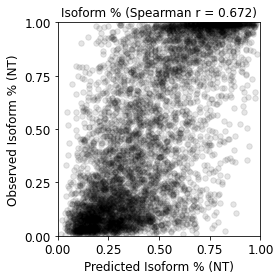

CPSF4
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


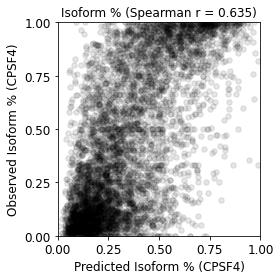

Difference prediction.
- P-value = 4.565079904429979e-105
- n = 5239


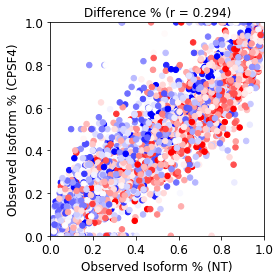

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


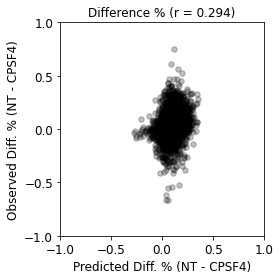


Precision (absolute).
- Average precision (classifier) = 0.78
- Average precision (by chance) = 0.66
- AP ratio = 1.17

Precision (relative).
- Average precision (classifier) = 0.64
- Average precision (by chance) = 0.5
- AP ratio = 1.29
CPSF6
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


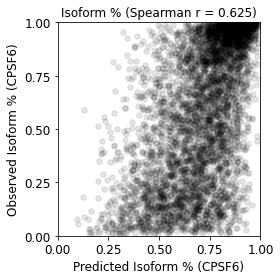

Difference prediction.
- P-value = 0.0
- n = 5239


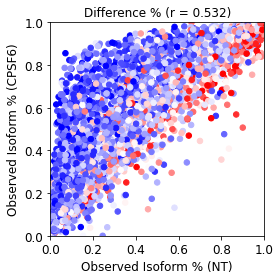

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


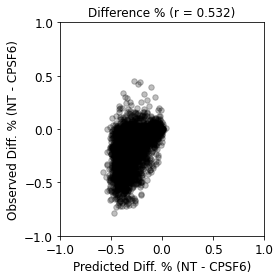


Precision (absolute).
- Average precision (classifier) = 0.33
- Average precision (by chance) = 0.13
- AP ratio = 2.54

Precision (relative).
- Average precision (classifier) = 0.78
- Average precision (by chance) = 0.5
- AP ratio = 1.55
CSTF1
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


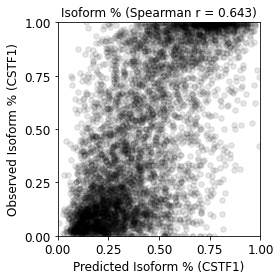

Difference prediction.
- P-value = 6.076265638919539e-75
- n = 5239


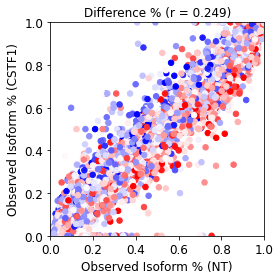

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


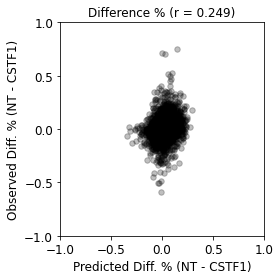


Precision (absolute).
- Average precision (classifier) = 0.66
- Average precision (by chance) = 0.56
- AP ratio = 1.18

Precision (relative).
- Average precision (classifier) = 0.6
- Average precision (by chance) = 0.5
- AP ratio = 1.21
CSTF3
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


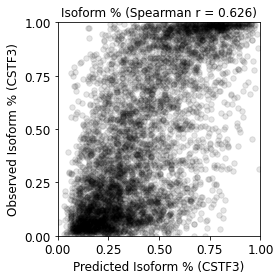

Difference prediction.
- P-value = 7.275936227178114e-134
- n = 5239


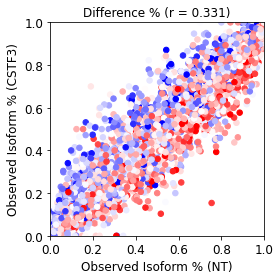

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


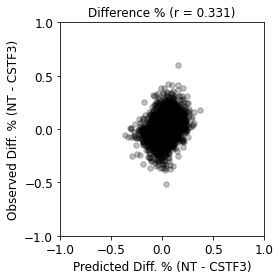


Precision (absolute).
- Average precision (classifier) = 0.71
- Average precision (by chance) = 0.56
- AP ratio = 1.28

Precision (relative).
- Average precision (classifier) = 0.67
- Average precision (by chance) = 0.5
- AP ratio = 1.33
FIP1L1
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


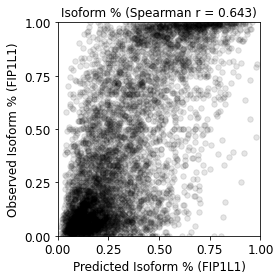

Difference prediction.
- P-value = 1.4011364561562373e-108
- n = 5239


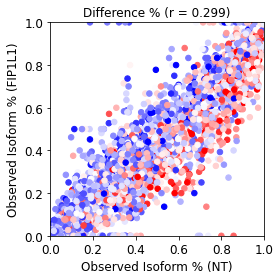

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


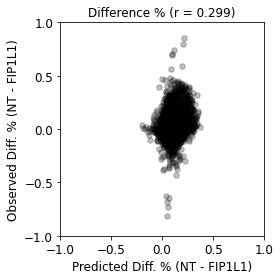


Precision (absolute).
- Average precision (classifier) = 0.82
- Average precision (by chance) = 0.72
- AP ratio = 1.14

Precision (relative).
- Average precision (classifier) = 0.65
- Average precision (by chance) = 0.5
- AP ratio = 1.29
NUDT21
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


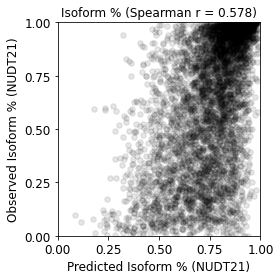

Difference prediction.
- P-value = 0.0
- n = 5239


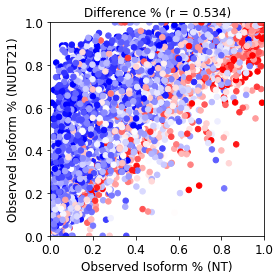

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


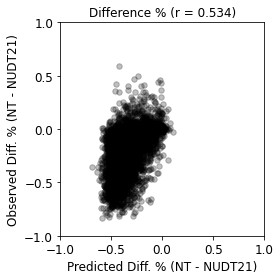


Precision (absolute).
- Average precision (classifier) = 0.34
- Average precision (by chance) = 0.14
- AP ratio = 2.44

Precision (relative).
- Average precision (classifier) = 0.77
- Average precision (by chance) = 0.5
- AP ratio = 1.55
RBBP6
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


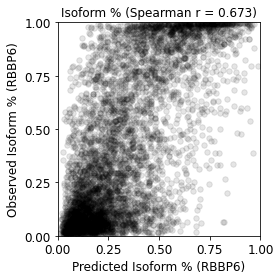

Difference prediction.
- P-value = 6.442891041162108e-54
- n = 5239


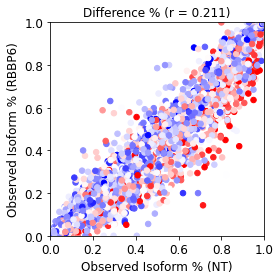

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


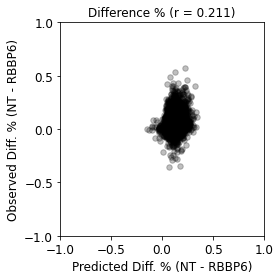


Precision (absolute).
- Average precision (classifier) = 0.82
- Average precision (by chance) = 0.78
- AP ratio = 1.05

Precision (relative).
- Average precision (classifier) = 0.6
- Average precision (by chance) = 0.5
- AP ratio = 1.2
SRSF3
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


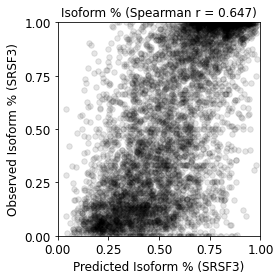

Difference prediction.
- P-value = 1.491211767839057e-45
- n = 5239


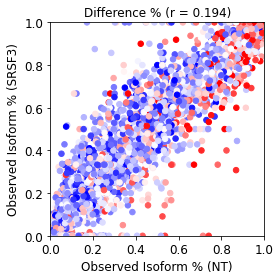

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


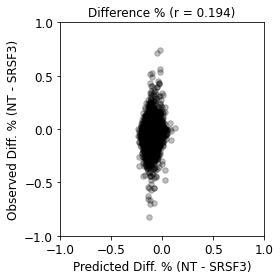


Precision (absolute).
- Average precision (classifier) = 0.38
- Average precision (by chance) = 0.32
- AP ratio = 1.18

Precision (relative).
- Average precision (classifier) = 0.61
- Average precision (by chance) = 0.5
- AP ratio = 1.22
SYMPK
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


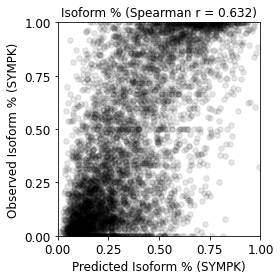

Difference prediction.
- P-value = 2.4072686908645246e-54
- n = 5239


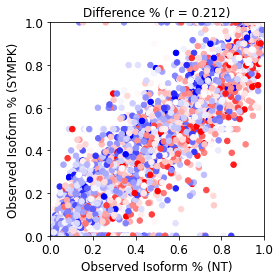

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


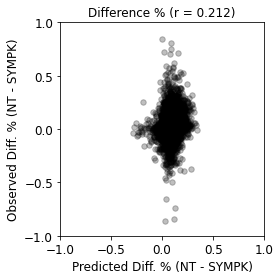


Precision (absolute).
- Average precision (classifier) = 0.74
- Average precision (by chance) = 0.66
- AP ratio = 1.13

Precision (relative).
- Average precision (classifier) = 0.6
- Average precision (by chance) = 0.5
- AP ratio = 1.21
THOC5
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


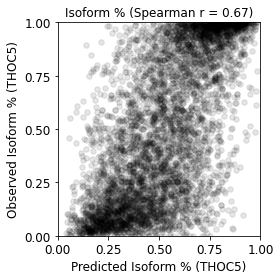

Difference prediction.
- P-value = 5.635625589533074e-165
- n = 5239


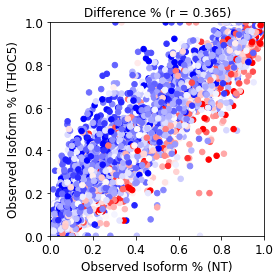

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


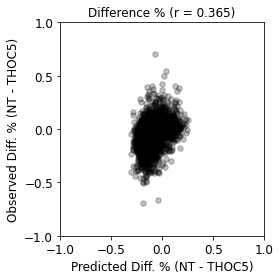


Precision (absolute).
- Average precision (classifier) = 0.53
- Average precision (by chance) = 0.36
- AP ratio = 1.48

Precision (relative).
- Average precision (classifier) = 0.68
- Average precision (by chance) = 0.5
- AP ratio = 1.36


In [30]:
#Differential usage analysis

from sklearn.metrics import average_precision_score

cell_type_1 = cell_types[0]

count_filter = 1
min_y_diff = 0.0
pas_ix = 0

print("PAS " + str(pas_ix) + ":")

for cell_type_2 in cell_types.tolist() :

    print(cell_type_2)
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]

    c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)
    c_total_2 = np.sum(c[:, cell_type_2_ix, :], axis=-1)

    y_kept = y[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    s_kept = s[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    m_kept = m[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    y_1 = y_kept[:, cell_type_1_ix, :]
    y_2 = y_kept[:, cell_type_2_ix, :]

    y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
    y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]
    
    if np.sign(pas_ix) == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) >= min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) >= min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) >= min_y_diff]
    y_diff = y_diff[np.abs(y_diff) >= min_y_diff]

    print("Absolute prediction.")
    
    r_val, p_val = spearmanr(y_2_flat, y_pred_2_flat)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_2_flat.shape[0]))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_2_flat, y_2_flat, s=30, c='black', alpha=0.1)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

    plt.xlabel("Predicted Isoform % (" + str(cell_type_2) + ")", fontsize=12)
    plt.ylabel("Observed Isoform % (" + str(cell_type_2) + ")", fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.png', transparent=True, dpi=600)
    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.eps')

    plt.show()
    
    if cell_type_2 != cell_type_1 :
        
        print("Difference prediction.")

        r_val, p_val = spearmanr(y_diff, y_pred_diff)

        print("- P-value = " + str(p_val))
        print("- n = " + str(y_diff.shape[0]))

        f = plt.figure(figsize=(4, 4))

        vmin = np.quantile(y_pred_diff, q=0.02)
        vmax = np.quantile(y_pred_diff, q=0.98)

        plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
        plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

        plt.xlabel("Observed Isoform % (" + cell_type_1 + ")", fontsize=12)
        plt.ylabel("Observed Isoform % (" + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.eps')

        plt.show()

        f = plt.figure(figsize=(4, 4))

        plt.scatter(y_pred_diff, y_diff, s=30, c='black', alpha=0.25)#, alpha=0.25

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
        plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

        plt.xlabel("Predicted Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)
        plt.ylabel("Observed Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.eps')

        plt.show()
        
        #Evaluate absolute difference classification performance
        
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > 0.] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (absolute).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))
        
        #Evaluate ability to classify more/less differential than median
        
        y_diff_median = np.median(y_diff)
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > y_diff_median] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (relative).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))


PAS -1:
NT
Absolute prediction.
- P-value = 0.0
- n = 5239


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

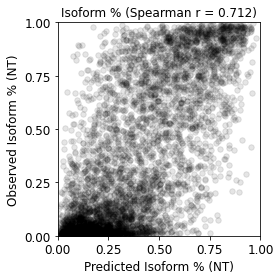

CPSF4
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


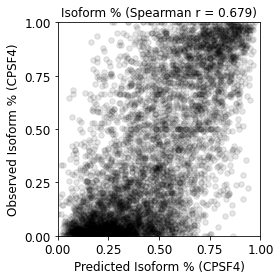

Difference prediction.
- P-value = 3.1736976314782162e-40
- n = 5239


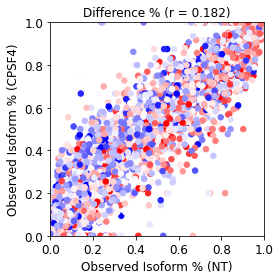

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


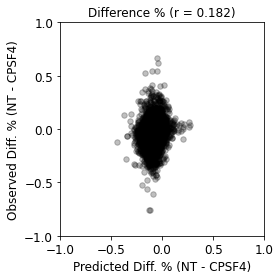

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.42
- Average precision (by chance) = 0.32
- AP ratio = 1.3

Precision (relative).
- Average precision (classifier) = 0.59
- Average precision (by chance) = 0.5
- AP ratio = 1.18
CPSF6
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


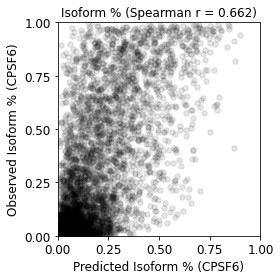

Difference prediction.
- P-value = 0.0
- n = 5239


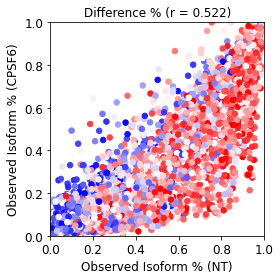

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


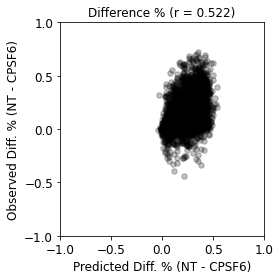

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.92
- Average precision (by chance) = 0.83
- AP ratio = 1.11

Precision (relative).
- Average precision (classifier) = 0.76
- Average precision (by chance) = 0.5
- AP ratio = 1.51
CSTF1
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


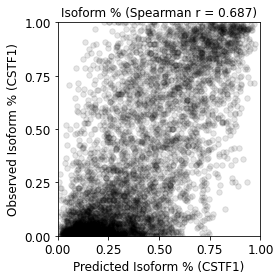

Difference prediction.
- P-value = 1.729259715982405e-52
- n = 5239


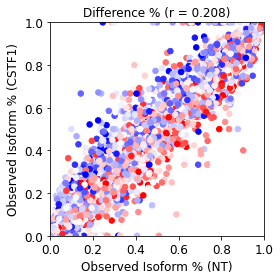

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


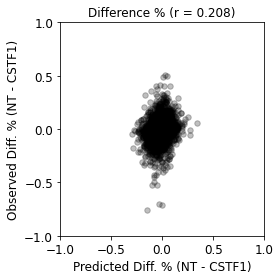

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.52
- Average precision (by chance) = 0.42
- AP ratio = 1.24

Precision (relative).
- Average precision (classifier) = 0.59
- Average precision (by chance) = 0.5
- AP ratio = 1.17
CSTF3
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


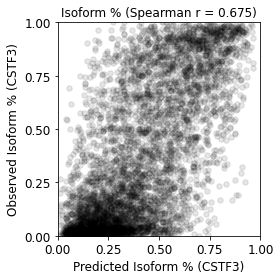

Difference prediction.
- P-value = 3.7809658533892784e-99
- n = 5239


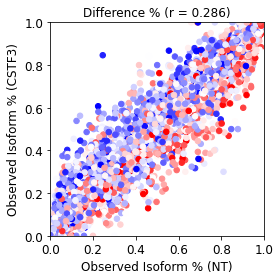

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


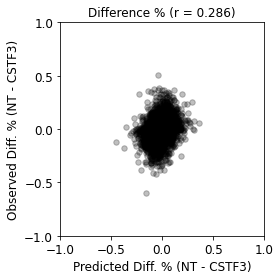

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.56
- Average precision (by chance) = 0.39
- AP ratio = 1.43

Precision (relative).
- Average precision (classifier) = 0.64
- Average precision (by chance) = 0.5
- AP ratio = 1.28
FIP1L1
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


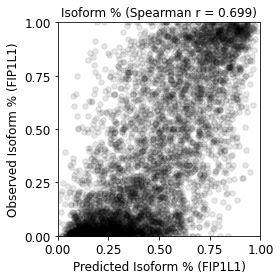

Difference prediction.
- P-value = 2.4374296004202265e-59
- n = 5239


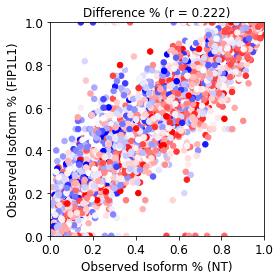

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


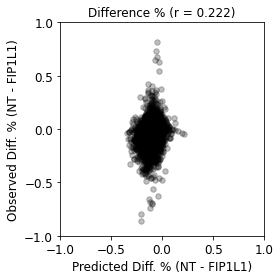

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.34
- Average precision (by chance) = 0.26
- AP ratio = 1.3

Precision (relative).
- Average precision (classifier) = 0.59
- Average precision (by chance) = 0.5
- AP ratio = 1.18
NUDT21
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


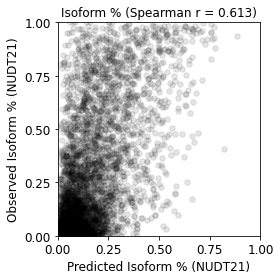

Difference prediction.
- P-value = 0.0
- n = 5239


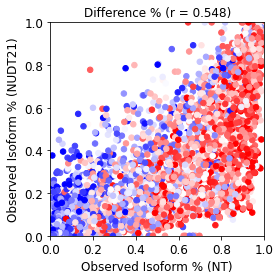

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


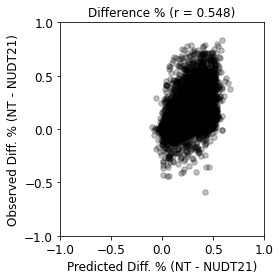

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.91
- Average precision (by chance) = 0.82
- AP ratio = 1.12

Precision (relative).
- Average precision (classifier) = 0.79
- Average precision (by chance) = 0.5
- AP ratio = 1.57
RBBP6
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


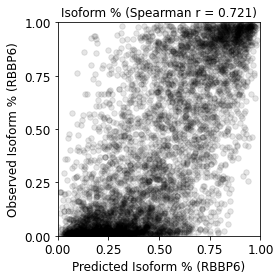

Difference prediction.
- P-value = 4.465390523671311e-79
- n = 5239


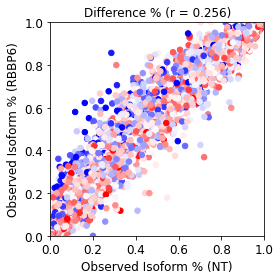

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


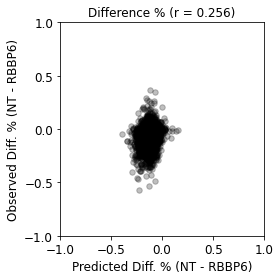

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.25
- Average precision (by chance) = 0.21
- AP ratio = 1.22

Precision (relative).
- Average precision (classifier) = 0.63
- Average precision (by chance) = 0.5
- AP ratio = 1.26
SRSF3
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


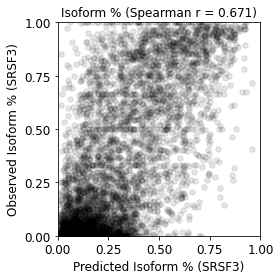

Difference prediction.
- P-value = 7.036032571134064e-77
- n = 5239


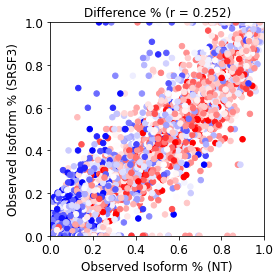

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


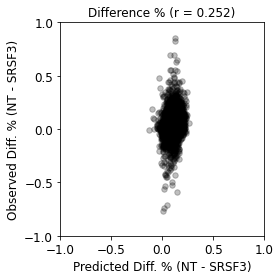

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.74
- Average precision (by chance) = 0.68
- AP ratio = 1.08

Precision (relative).
- Average precision (classifier) = 0.63
- Average precision (by chance) = 0.5
- AP ratio = 1.27
SYMPK
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


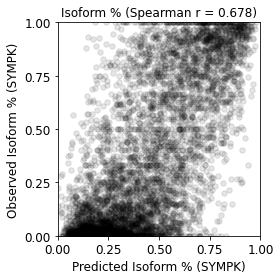

Difference prediction.
- P-value = 7.180666563653999e-25
- n = 5239


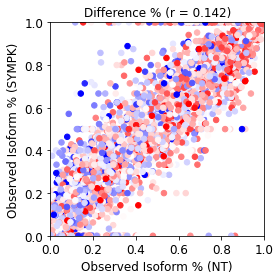

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


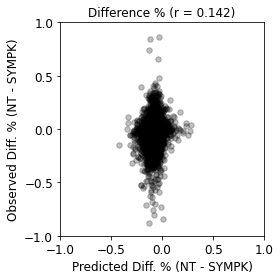

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.4
- Average precision (by chance) = 0.34
- AP ratio = 1.18

Precision (relative).
- Average precision (classifier) = 0.56
- Average precision (by chance) = 0.5
- AP ratio = 1.12
THOC5
Absolute prediction.
- P-value = 0.0
- n = 5239


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


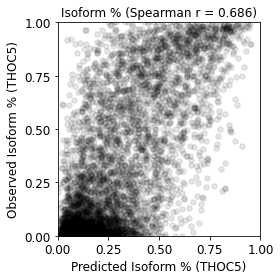

Difference prediction.
- P-value = 7.828632241611132e-176
- n = 5239


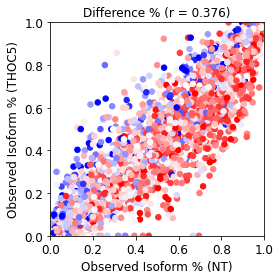

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


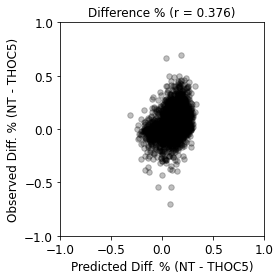


Precision (absolute).
- Average precision (classifier) = 0.76
- Average precision (by chance) = 0.64
- AP ratio = 1.2

Precision (relative).
- Average precision (classifier) = 0.7
- Average precision (by chance) = 0.5
- AP ratio = 1.39


In [32]:
#Differential usage analysis

from sklearn.metrics import average_precision_score

cell_type_1 = cell_types[0]

count_filter = 1
min_y_diff = 0.0
pas_ix = -1

print("PAS " + str(pas_ix) + ":")

for cell_type_2 in cell_types.tolist() :

    print(cell_type_2)
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]

    c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)
    c_total_2 = np.sum(c[:, cell_type_2_ix, :], axis=-1)

    y_kept = y[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    s_kept = s[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    m_kept = m[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    y_1 = y_kept[:, cell_type_1_ix, :]
    y_2 = y_kept[:, cell_type_2_ix, :]

    y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
    y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]
    
    if np.sign(pas_ix) == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) >= min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) >= min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) >= min_y_diff]
    y_diff = y_diff[np.abs(y_diff) >= min_y_diff]

    print("Absolute prediction.")
    
    r_val, p_val = spearmanr(y_2_flat, y_pred_2_flat)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_2_flat.shape[0]))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_2_flat, y_2_flat, s=30, c='black', alpha=0.1)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

    plt.xlabel("Predicted Isoform % (" + str(cell_type_2) + ")", fontsize=12)
    plt.ylabel("Observed Isoform % (" + str(cell_type_2) + ")", fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.png', transparent=True, dpi=600)
    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.eps')

    plt.show()
    
    if cell_type_2 != cell_type_1 :
        
        print("Difference prediction.")

        r_val, p_val = spearmanr(y_diff, y_pred_diff)

        print("- P-value = " + str(p_val))
        print("- n = " + str(y_diff.shape[0]))

        f = plt.figure(figsize=(4, 4))

        vmin = np.quantile(y_pred_diff, q=0.02)
        vmax = np.quantile(y_pred_diff, q=0.98)

        plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
        plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

        plt.xlabel("Observed Isoform % (" + cell_type_1 + ")", fontsize=12)
        plt.ylabel("Observed Isoform % (" + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.eps')

        plt.show()

        f = plt.figure(figsize=(4, 4))

        plt.scatter(y_pred_diff, y_diff, s=30, c='black', alpha=0.25)#, alpha=0.25

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
        plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

        plt.xlabel("Predicted Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)
        plt.ylabel("Observed Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.eps')

        plt.show()
        
        #Evaluate absolute difference classification performance
        
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > 0.] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (absolute).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))
        
        #Evaluate ability to classify more/less differential than median
        
        y_diff_median = np.median(y_diff)
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > y_diff_median] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (relative).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))


PAS 0:
NT
Absolute prediction.
- P-value = 0.0
- n = 5075


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


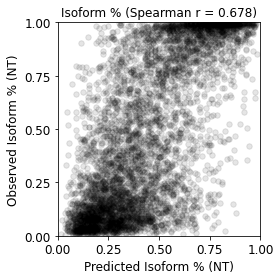

CPSF4
Absolute prediction.
- P-value = 0.0
- n = 2371


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


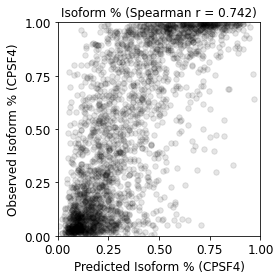

Difference prediction.
- P-value = 1.867760670382824e-102
- n = 2371


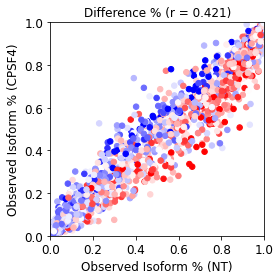

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


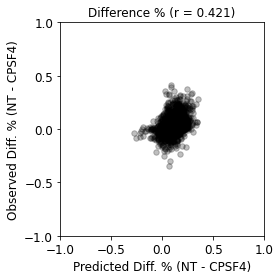


Precision (absolute).
- Average precision (classifier) = 0.85
- Average precision (by chance) = 0.7
- AP ratio = 1.22

Precision (relative).
- Average precision (classifier) = 0.71
- Average precision (by chance) = 0.5
- AP ratio = 1.42
CPSF6
Absolute prediction.
- P-value = 0.0
- n = 4738


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


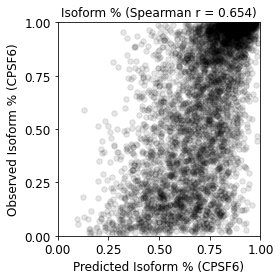

Difference prediction.
- P-value = 0.0
- n = 4738


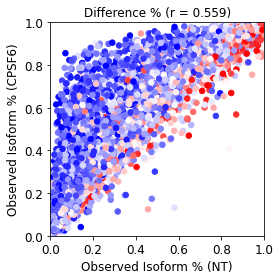

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


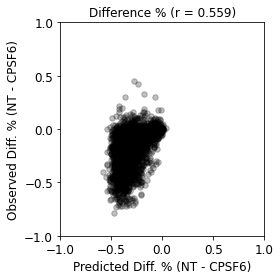


Precision (absolute).
- Average precision (classifier) = 0.34
- Average precision (by chance) = 0.12
- AP ratio = 2.81

Precision (relative).
- Average precision (classifier) = 0.79
- Average precision (by chance) = 0.5
- AP ratio = 1.59
CSTF1
Absolute prediction.
- P-value = 0.0
- n = 2945


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


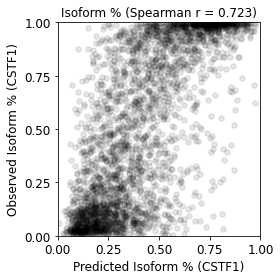

Difference prediction.
- P-value = 1.2629528120919839e-58
- n = 2945


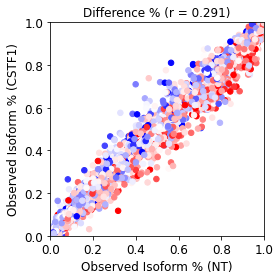

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


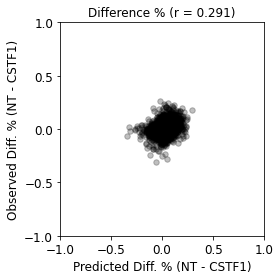


Precision (absolute).
- Average precision (classifier) = 0.7
- Average precision (by chance) = 0.58
- AP ratio = 1.21

Precision (relative).
- Average precision (classifier) = 0.63
- Average precision (by chance) = 0.5
- AP ratio = 1.25
CSTF3
Absolute prediction.
- P-value = 0.0
- n = 3803


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


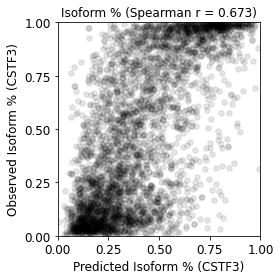

Difference prediction.
- P-value = 1.3019290720549556e-126
- n = 3803


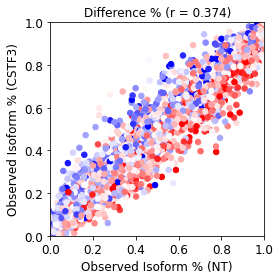

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


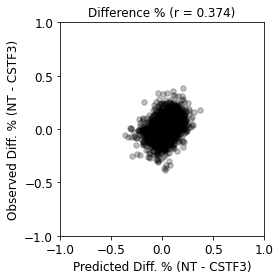


Precision (absolute).
- Average precision (classifier) = 0.74
- Average precision (by chance) = 0.56
- AP ratio = 1.31

Precision (relative).
- Average precision (classifier) = 0.69
- Average precision (by chance) = 0.5
- AP ratio = 1.38
FIP1L1
Absolute prediction.
- P-value = 0.0
- n = 2800


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


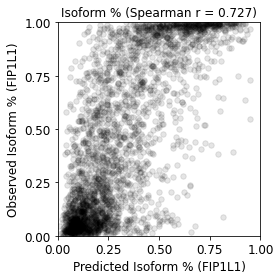

Difference prediction.
- P-value = 7.624671260198745e-108
- n = 2800


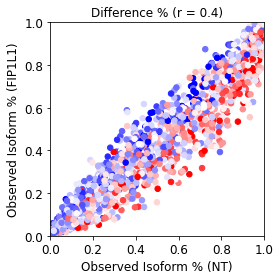

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


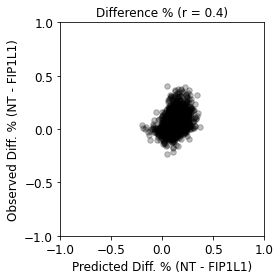


Precision (absolute).
- Average precision (classifier) = 0.87
- Average precision (by chance) = 0.74
- AP ratio = 1.17

Precision (relative).
- Average precision (classifier) = 0.7
- Average precision (by chance) = 0.5
- AP ratio = 1.39
NUDT21
Absolute prediction.
- P-value = 0.0
- n = 3884


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


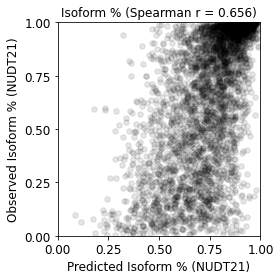

Difference prediction.
- P-value = 0.0
- n = 3884


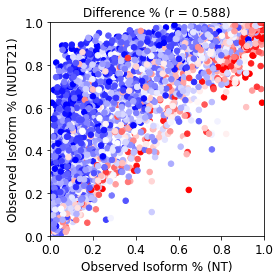

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


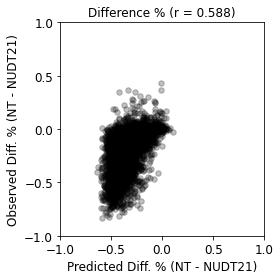


Precision (absolute).
- Average precision (classifier) = 0.36
- Average precision (by chance) = 0.13
- AP ratio = 2.83

Precision (relative).
- Average precision (classifier) = 0.81
- Average precision (by chance) = 0.5
- AP ratio = 1.61
RBBP6
Absolute prediction.
- P-value = 0.0
- n = 4192


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


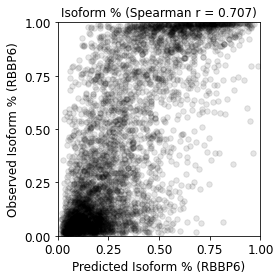

Difference prediction.
- P-value = 1.0094636295262268e-54
- n = 4192


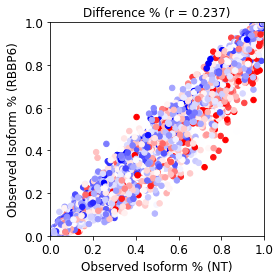

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


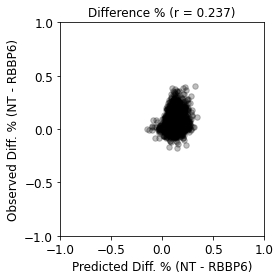


Precision (absolute).
- Average precision (classifier) = 0.83
- Average precision (by chance) = 0.79
- AP ratio = 1.05

Precision (relative).
- Average precision (classifier) = 0.6
- Average precision (by chance) = 0.5
- AP ratio = 1.21
SRSF3
Absolute prediction.
- P-value = 0.0
- n = 2559


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


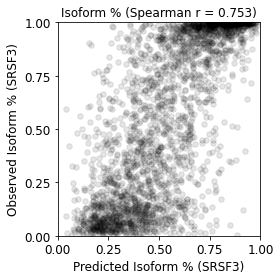

Difference prediction.
- P-value = 4.0323818786828667e-38
- n = 2559


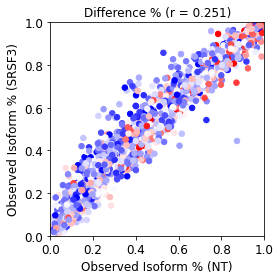

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


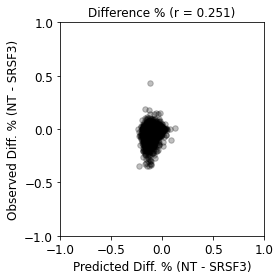


Precision (absolute).
- Average precision (classifier) = 0.37
- Average precision (by chance) = 0.3
- AP ratio = 1.25

Precision (relative).
- Average precision (classifier) = 0.65
- Average precision (by chance) = 0.5
- AP ratio = 1.3
SYMPK
Absolute prediction.
- P-value = 2e-323
- n = 1658


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


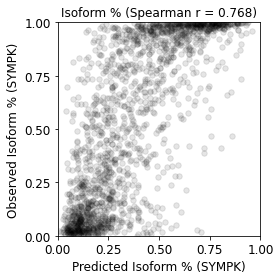

Difference prediction.
- P-value = 2.2110377816092845e-47
- n = 1658


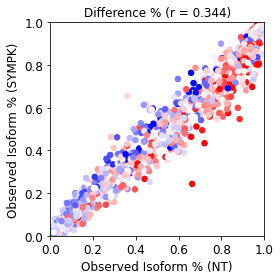

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


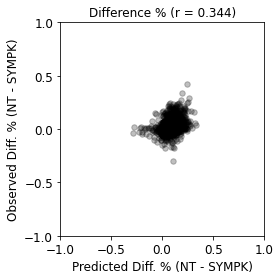


Precision (absolute).
- Average precision (classifier) = 0.82
- Average precision (by chance) = 0.71
- AP ratio = 1.16

Precision (relative).
- Average precision (classifier) = 0.68
- Average precision (by chance) = 0.5
- AP ratio = 1.35
THOC5
Absolute prediction.
- P-value = 0.0
- n = 3075


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


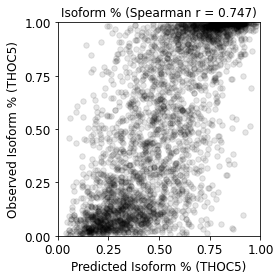

Difference prediction.
- P-value = 3.927395662648e-120
- n = 3075


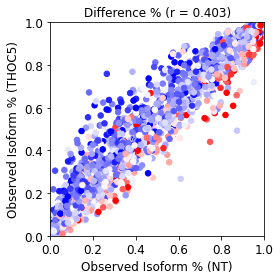

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


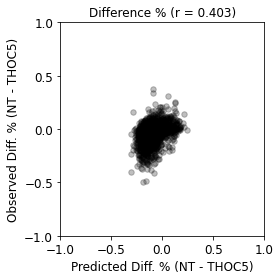


Precision (absolute).
- Average precision (classifier) = 0.53
- Average precision (by chance) = 0.36
- AP ratio = 1.5

Precision (relative).
- Average precision (classifier) = 0.7
- Average precision (by chance) = 0.5
- AP ratio = 1.4


In [33]:
#Differential usage analysis

from sklearn.metrics import average_precision_score

cell_type_1 = cell_types[0]

count_filter = 100
min_y_diff = 0.0
pas_ix = 0

print("PAS " + str(pas_ix) + ":")

for cell_type_2 in cell_types.tolist() :

    print(cell_type_2)
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]

    c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)
    c_total_2 = np.sum(c[:, cell_type_2_ix, :], axis=-1)

    y_kept = y[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    s_kept = s[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    m_kept = m[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    y_1 = y_kept[:, cell_type_1_ix, :]
    y_2 = y_kept[:, cell_type_2_ix, :]

    y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
    y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]
    
    if np.sign(pas_ix) == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) >= min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) >= min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) >= min_y_diff]
    y_diff = y_diff[np.abs(y_diff) >= min_y_diff]

    print("Absolute prediction.")
    
    r_val, p_val = spearmanr(y_2_flat, y_pred_2_flat)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_2_flat.shape[0]))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_2_flat, y_2_flat, s=30, c='black', alpha=0.1)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

    plt.xlabel("Predicted Isoform % (" + str(cell_type_2) + ")", fontsize=12)
    plt.ylabel("Observed Isoform % (" + str(cell_type_2) + ")", fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.png', transparent=True, dpi=600)
    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.eps')

    plt.show()
    
    if cell_type_2 != cell_type_1 :
        
        print("Difference prediction.")

        r_val, p_val = spearmanr(y_diff, y_pred_diff)

        print("- P-value = " + str(p_val))
        print("- n = " + str(y_diff.shape[0]))

        f = plt.figure(figsize=(4, 4))

        vmin = np.quantile(y_pred_diff, q=0.02)
        vmax = np.quantile(y_pred_diff, q=0.98)

        plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
        plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

        plt.xlabel("Observed Isoform % (" + cell_type_1 + ")", fontsize=12)
        plt.ylabel("Observed Isoform % (" + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.eps')

        plt.show()

        f = plt.figure(figsize=(4, 4))

        plt.scatter(y_pred_diff, y_diff, s=30, c='black', alpha=0.25)#, alpha=0.25

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
        plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

        plt.xlabel("Predicted Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)
        plt.ylabel("Observed Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.eps')

        plt.show()
        
        #Evaluate absolute difference classification performance
        
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > 0.] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (absolute).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))
        
        #Evaluate ability to classify more/less differential than median
        
        y_diff_median = np.median(y_diff)
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > y_diff_median] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (relative).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

PAS -1:
NT
Absolute prediction.
- P-value = 0.0
- n = 5075


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


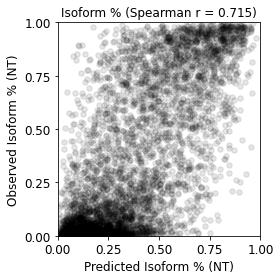

CPSF4
Absolute prediction.
- P-value = 4.615e-321
- n = 2371


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


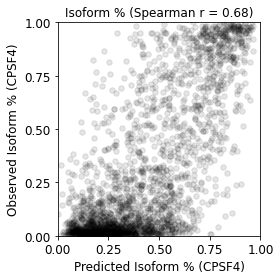

Difference prediction.
- P-value = 8.006173641796535e-33
- n = 2371


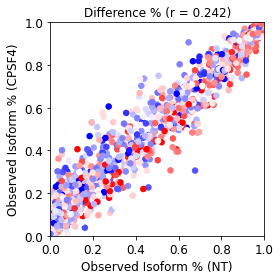

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


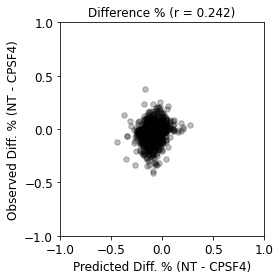

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.4
- Average precision (by chance) = 0.26
- AP ratio = 1.53

Precision (relative).
- Average precision (classifier) = 0.6
- Average precision (by chance) = 0.5
- AP ratio = 1.21
CPSF6
Absolute prediction.
- P-value = 0.0
- n = 4738


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


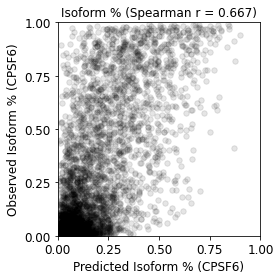

Difference prediction.
- P-value = 0.0
- n = 4738


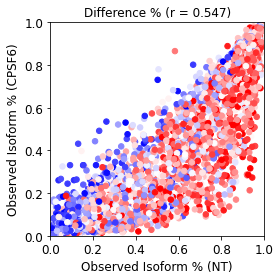

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


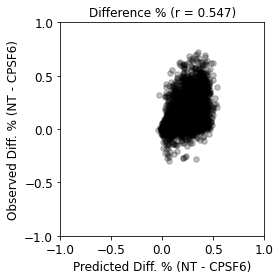

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.93
- Average precision (by chance) = 0.83
- AP ratio = 1.11

Precision (relative).
- Average precision (classifier) = 0.77
- Average precision (by chance) = 0.5
- AP ratio = 1.55
CSTF1
Absolute prediction.
- P-value = 0.0
- n = 2945


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


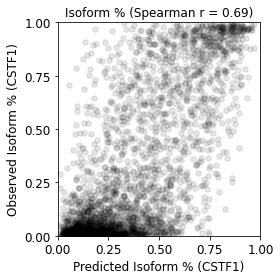

Difference prediction.
- P-value = 6.476984283014311e-39
- n = 2945


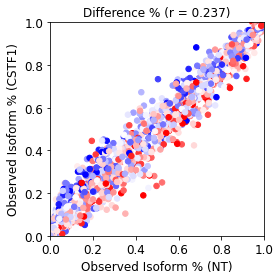

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


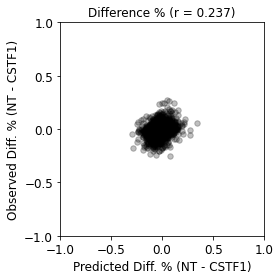

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.5
- Average precision (by chance) = 0.39
- AP ratio = 1.28

Precision (relative).
- Average precision (classifier) = 0.59
- Average precision (by chance) = 0.5
- AP ratio = 1.18
CSTF3
Absolute prediction.
- P-value = 0.0
- n = 3803


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


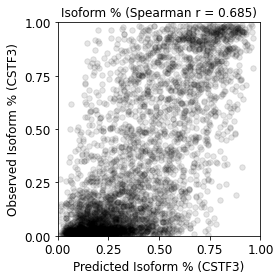

Difference prediction.
- P-value = 1.9669440355496683e-79
- n = 3803


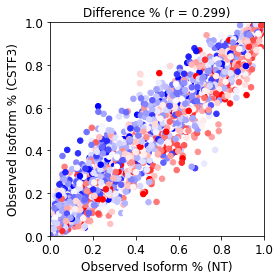

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


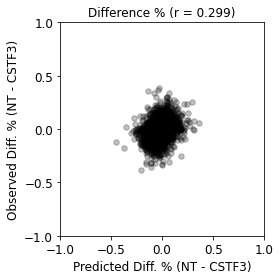

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.55
- Average precision (by chance) = 0.37
- AP ratio = 1.5

Precision (relative).
- Average precision (classifier) = 0.65
- Average precision (by chance) = 0.5
- AP ratio = 1.3
FIP1L1
Absolute prediction.
- P-value = 0.0
- n = 2800


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


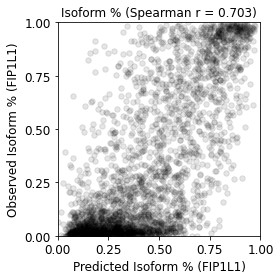

Difference prediction.
- P-value = 2.2514371939206594e-48
- n = 2800


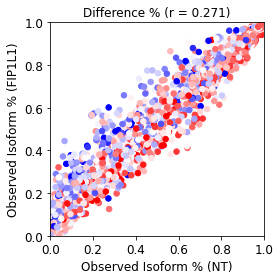

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


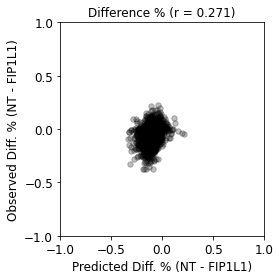

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.34
- Average precision (by chance) = 0.23
- AP ratio = 1.48

Precision (relative).
- Average precision (classifier) = 0.61
- Average precision (by chance) = 0.5
- AP ratio = 1.23
NUDT21
Absolute prediction.
- P-value = 0.0
- n = 3884


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


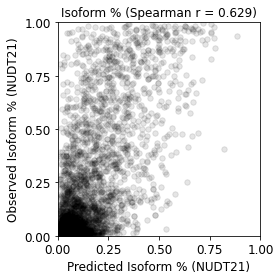

Difference prediction.
- P-value = 0.0
- n = 3884


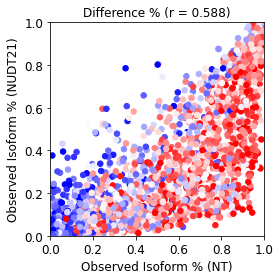

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


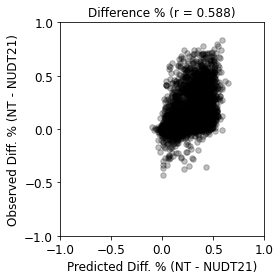

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.93
- Average precision (by chance) = 0.83
- AP ratio = 1.12

Precision (relative).
- Average precision (classifier) = 0.81
- Average precision (by chance) = 0.5
- AP ratio = 1.63
RBBP6
Absolute prediction.
- P-value = 0.0
- n = 4192


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


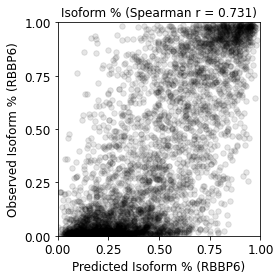

Difference prediction.
- P-value = 1.030113735775371e-79
- n = 4192


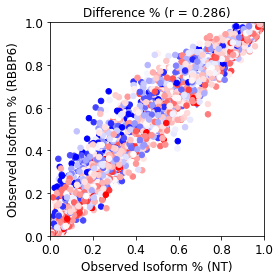

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


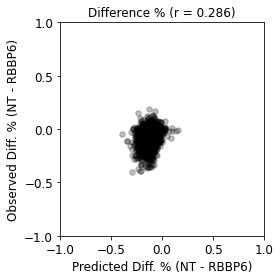

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.25
- Average precision (by chance) = 0.19
- AP ratio = 1.29

Precision (relative).
- Average precision (classifier) = 0.64
- Average precision (by chance) = 0.5
- AP ratio = 1.28
SRSF3
Absolute prediction.
- P-value = 0.0
- n = 2559


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


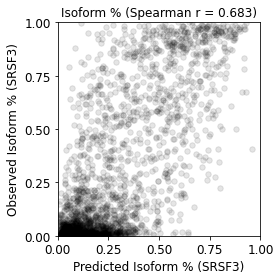

Difference prediction.
- P-value = 1.8753544555083716e-53
- n = 2559


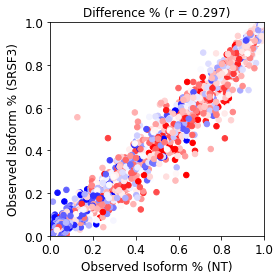

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


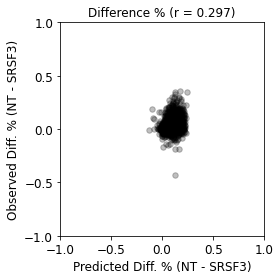

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.75
- Average precision (by chance) = 0.7
- AP ratio = 1.07

Precision (relative).
- Average precision (classifier) = 0.65
- Average precision (by chance) = 0.5
- AP ratio = 1.29
SYMPK
Absolute prediction.
- P-value = 2.9596912391643584e-226
- n = 1658


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


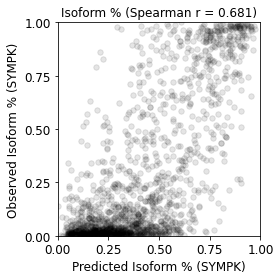

Difference prediction.
- P-value = 2.6646151895108112e-17
- n = 1658


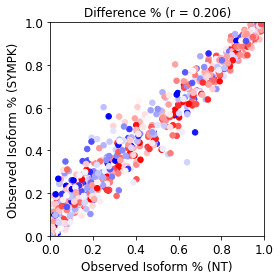

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


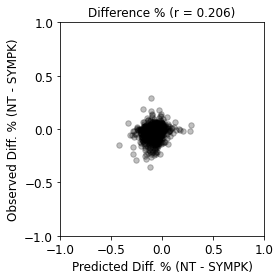

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat


Precision (absolute).
- Average precision (classifier) = 0.34
- Average precision (by chance) = 0.25
- AP ratio = 1.36

Precision (relative).
- Average precision (classifier) = 0.57
- Average precision (by chance) = 0.5
- AP ratio = 1.14
THOC5
Absolute prediction.
- P-value = 0.0
- n = 3075


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


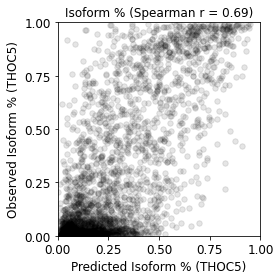

Difference prediction.
- P-value = 2.2497607658603524e-125
- n = 3075


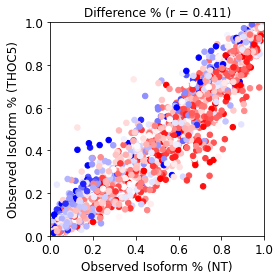

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


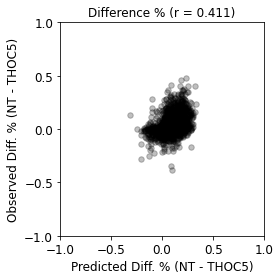


Precision (absolute).
- Average precision (classifier) = 0.77
- Average precision (by chance) = 0.64
- AP ratio = 1.21

Precision (relative).
- Average precision (classifier) = 0.71
- Average precision (by chance) = 0.5
- AP ratio = 1.42


In [34]:
#Differential usage analysis

from sklearn.metrics import average_precision_score

cell_type_1 = cell_types[0]

count_filter = 100
min_y_diff = 0.0
pas_ix = -1

print("PAS " + str(pas_ix) + ":")

for cell_type_2 in cell_types.tolist() :

    print(cell_type_2)
    
    cell_type_1_ix = cell_type_dict[cell_type_1]
    cell_type_2_ix = cell_type_dict[cell_type_2]

    c_total_1 = np.sum(c[:, cell_type_1_ix, :], axis=-1)
    c_total_2 = np.sum(c[:, cell_type_2_ix, :], axis=-1)

    y_kept = y[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_score_kept = y_pred_score[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    y_pred_prob_kept = y_pred_prob[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    s_kept = s[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]
    m_kept = m[(c_total_1 >= count_filter) & (c_total_2 >= count_filter), ...]

    y_1 = y_kept[:, cell_type_1_ix, :]
    y_2 = y_kept[:, cell_type_2_ix, :]

    y_pred_1 = y_pred_prob_kept[:, cell_type_1_ix, :]
    y_pred_2 = y_pred_prob_kept[:, cell_type_2_ix, :]

    m_flat = m_kept[:, pas_ix]

    y_1_flat = y_1[:, pas_ix]
    y_2_flat = y_2[:, pas_ix]

    y_pred_1_flat = y_pred_1[:, pas_ix]
    y_pred_2_flat = y_pred_2[:, pas_ix]
    
    if np.sign(pas_ix) == -1 :
        m_flat = m_kept[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_1_flat = y_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_2_flat = y_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

        y_pred_1_flat = y_pred_1[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]
        y_pred_2_flat = y_pred_2[np.arange(m_kept.shape[0]), np.array(np.sum(m_kept, axis=1), dtype=np.int) + pas_ix]

    y_1_flat = y_1_flat[m_flat >= 1.]
    y_2_flat = y_2_flat[m_flat >= 1.]

    y_pred_1_flat = y_pred_1_flat[m_flat >= 1.]
    y_pred_2_flat = y_pred_2_flat[m_flat >= 1.]

    y_diff = y_1_flat - y_2_flat
    y_pred_diff = y_pred_1_flat - y_pred_2_flat

    #Re-filter on significant difference
    y_1_flat = y_1_flat[np.abs(y_diff) >= min_y_diff]
    y_2_flat = y_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_1_flat = y_pred_1_flat[np.abs(y_diff) >= min_y_diff]
    y_pred_2_flat = y_pred_2_flat[np.abs(y_diff) >= min_y_diff]

    y_pred_diff = y_pred_diff[np.abs(y_diff) >= min_y_diff]
    y_diff = y_diff[np.abs(y_diff) >= min_y_diff]

    print("Absolute prediction.")
    
    r_val, p_val = spearmanr(y_2_flat, y_pred_2_flat)

    print("- P-value = " + str(p_val))
    print("- n = " + str(y_2_flat.shape[0]))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred_2_flat, y_2_flat, s=30, c='black', alpha=0.1)

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

    plt.xlabel("Predicted Isoform % (" + str(cell_type_2) + ")", fontsize=12)
    plt.ylabel("Observed Isoform % (" + str(cell_type_2) + ")", fontsize=12)

    plt.title("Isoform % (Spearman r = " + str(round(r_val, 3)) + ")", fontsize=12)

    plt.tight_layout()

    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.png', transparent=True, dpi=600)
    plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter_reconstruction.eps')

    plt.show()
    
    if cell_type_2 != cell_type_1 :
        
        print("Difference prediction.")

        r_val, p_val = spearmanr(y_diff, y_pred_diff)

        print("- P-value = " + str(p_val))
        print("- n = " + str(y_diff.shape[0]))

        f = plt.figure(figsize=(4, 4))

        vmin = np.quantile(y_pred_diff, q=0.02)
        vmax = np.quantile(y_pred_diff, q=0.98)

        plt.scatter(y_1_flat, y_2_flat, s=30, c=y_pred_diff, cmap='bwr', vmin=vmin, vmax=vmax)

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
        plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

        plt.xlabel("Observed Isoform % (" + cell_type_1 + ")", fontsize=12)
        plt.ylabel("Observed Isoform % (" + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_color.eps')

        plt.show()

        f = plt.figure(figsize=(4, 4))

        plt.scatter(y_pred_diff, y_diff, s=30, c='black', alpha=0.25)#, alpha=0.25

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.xticks([-1, -0.5, 0., 0.5, 1], fontsize=12)
        plt.yticks([-1, -0.5, 0., 0.5, 1], fontsize=12)

        plt.xlabel("Predicted Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)
        plt.ylabel("Observed Diff. % (" + cell_type_1 + " - " + cell_type_2 + ")", fontsize=12)

        plt.title("Difference % (r = " + str(round(r_val, 3)) + ")", fontsize=12)

        plt.tight_layout()

        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.png', transparent=True, dpi=600)
        plt.savefig(model_name + '_ensemble_cell_type_2_' + str(cell_type_2) + '_pas_' + str(pas_ix) + '_min_count_' + str(count_filter) + '_scatter.eps')

        plt.show()
        
        #Evaluate absolute difference classification performance
        
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > 0.] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (absolute).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))
        
        #Evaluate ability to classify more/less differential than median
        
        y_diff_median = np.median(y_diff)
        y_diff_labels = np.zeros(y_diff.shape[0])
        y_diff_labels[y_diff > y_diff_median] = 1.
        
        ap = average_precision_score(y_diff_labels, y_pred_diff)
        
        ap_by_chance = np.sum(y_diff_labels) / y_diff_labels.shape[0]
        
        print("")
        print("Precision (relative).")
        print("- Average precision (classifier) = " + str(round(ap, 2)))
        print("- Average precision (by chance) = " + str(round(ap_by_chance, 2)))
        print("- AP ratio = " + str(round(ap / ap_by_chance, 2)))
